In [84]:
import pandas as pd
reviews = pd.read_csv("reviews.csv").drop(columns=['uid','link','scores','text'])
animes = pd.read_csv("animes.csv",index_col=0).drop(columns=['popularity','aired','members','ranked','score','img_url','link'])
usuarios = pd.read_csv("profiles.csv",index_col=0).drop(columns=['favorites_anime','link','birthday','gender'])

In [83]:
usuarios.head(5)

""
profile
DesolatePsyche
baekbeans
skrn
edgewalker00
aManOfCulture99


In [85]:
animes.head(5)

,title,synopsis,genre,episodes
uid,,,,
28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0
23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0
34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0
5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0
31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0


In [4]:
reviews.head(5)

,profile,anime_uid,score
0,DesolatePsyche,34096,8
1,baekbeans,34599,10
2,skrn,28891,7
3,edgewalker00,2904,9
4,aManOfCulture99,4181,10


<BarContainer object of 12 artists>

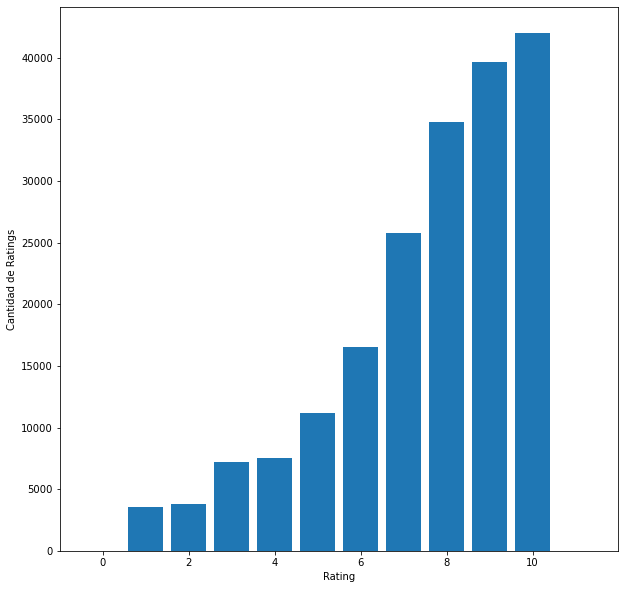

In [5]:
import matplotlib.pyplot as plt
#Distribución del score de las evaluaciones.
data = reviews['score'].value_counts().sort_index(ascending=False)

plt.figure(figsize=(10, 10))
plt.ylabel("Cantidad de Ratings")
plt.xlabel("Rating")
plt.bar(data.index,data.values)

In [6]:
print('Animes: ',animes['uid'].count())
print('Usuarios: ',usuarios['profile'].count())
print('Reviews: ',reviews['profile'].count())

Animes:  19311
Usuarios:  81727
Reviews:  192112


In [7]:
from surprise import SVD, SlopeOne, CoClustering
from surprise import Reader, Dataset
from surprise.accuracy import rmse

reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(reviews,reader)

In [8]:
from surprise.model_selection import cross_validate

#Singular Value Decomposition (SVD)
r1 = cross_validate(SVD(), data, measures = ['RMSE'], cv = 10,return_train_measures=True, verbose = False)

#Slope One (the simplest form of non-trivial item-based collaborative filtering based on ratings)
r2 = cross_validate(SlopeOne(), data, measures = ['RMSE'],return_train_measures=True, cv = 10, verbose = False)

#CoClustering
r3 = cross_validate(CoClustering(), data, measures=['RMSE'],return_train_measures=True, cv=10, verbose=False)

In [9]:
grupo = []
svdCrss = pd.DataFrame.from_dict(r1).mean(axis=0)
svdCrss = svdCrss.append(pd.Series([str("SVD")], index= ['Método']))
SOCrss = pd.DataFrame.from_dict(r2).mean(axis=0)
SOCrss = SOCrss.append(pd.Series([str("Slope One")], index= ['Método']))
CoCCrss = pd.DataFrame.from_dict(r3).mean(axis=0)
CoCCrss = CoCCrss.append(pd.Series([str("Co Clustering")], index= ['Método']))
grupo.append(svdCrss)
grupo.append(SOCrss)
grupo.append(CoCCrss)

resultados = pd.DataFrame(grupo).set_index("Método").sort_values('test_rmse')
resultados

,test_rmse,train_rmse,fit_time,test_time
Método,,,,
SVD,1.444846,0.720130,7.873987,0.133971
Slope One,1.677218,0.679304,1.798130,0.521415
Co Clustering,1.790489,1.308271,7.430485,0.090419


Text(0.5, 1.0, 'RMSE')

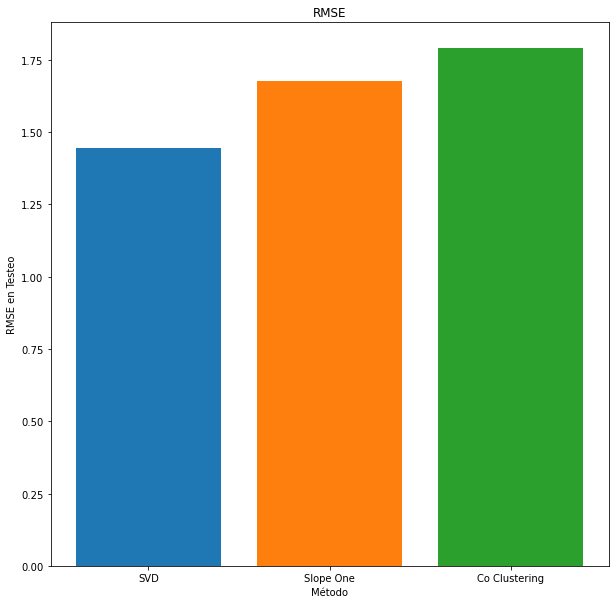

In [10]:
plt.figure(figsize=(10,10))
for metodo in resultados.index:
    plt.bar(metodo, resultados['test_rmse'][metodo])
plt.ylabel("RMSE en Testeo")
plt.xlabel("Método")
plt.title("RMSE")

In [11]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size= 0.25)

In [12]:
from surprise.accuracy import rmse
#SlopOne
slopeOne = SlopeOne()
slopeOne.fit(trainset)
predictionsSlopeOne = slopeOne.test(testset)
#SVD
svd = SVD()
svd.fit(trainset)
prediciontsSVD = svd.test(testset)
#CoClustering
coClustering = CoClustering()
coClustering.fit(trainset)
predictionscoClustering = coClustering.test(testset)
print("RMSE SlopeOne:",rmse(predictionsSlopeOne))
print("RMSE SVD:",rmse(prediciontsSVD))
print("RMSE CoClustering:",rmse(predictionscoClustering))

<ipython-input-12-727c36771aae>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  slopeOne.fit(trainset)
<ipython-input-12-727c36771aae>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details

RMSE: 1.7702
RMSE SlopeOne: 1.77020247070022
RMSE: 1.5475
RMSE SVD: 1.5475232382913202
RMSE: 1.8296
RMSE CoClustering: 1.8296041715868783


Text(0.5, 1.0, 'Error cuadrático medio en Training Set')

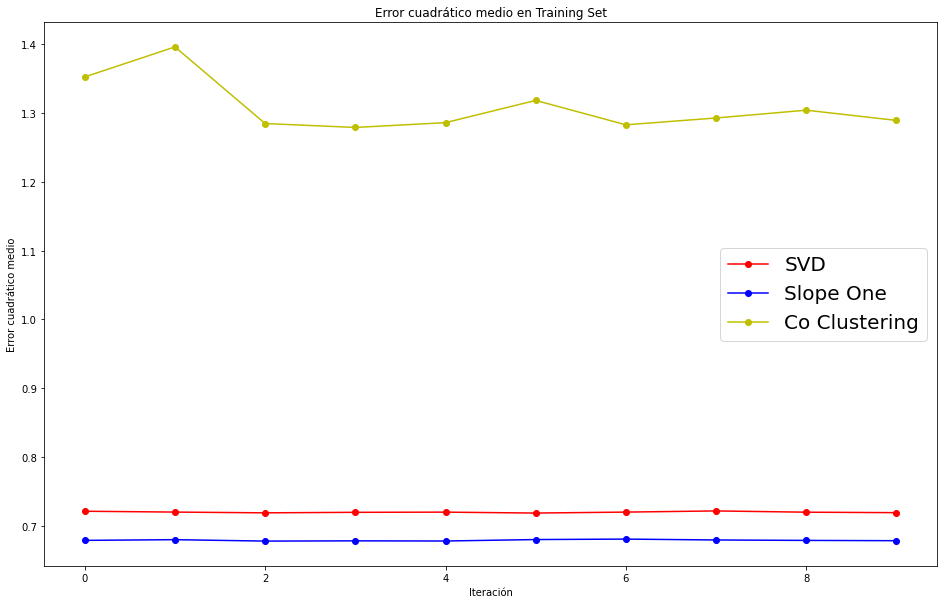

In [29]:
plt.figure(figsize=(16,10))
plt.ylabel("Error cuadrático medio")
plt.xlabel("Iteración")
plt.plot(range(10),r1['train_rmse'],'-o',color='r',label="SVD")
plt.plot(range(10),r2['train_rmse'],'-o',color='b',label="Slope One")
plt.plot(range(10),r3['train_rmse'],'-o',color='y',label="Co Clustering")
plt.legend(loc="right",prop={'size':20})
plt.title("Error cuadrático medio en Training Set")

Text(0.5, 1.0, 'Error cuadrático medio en Test Set')

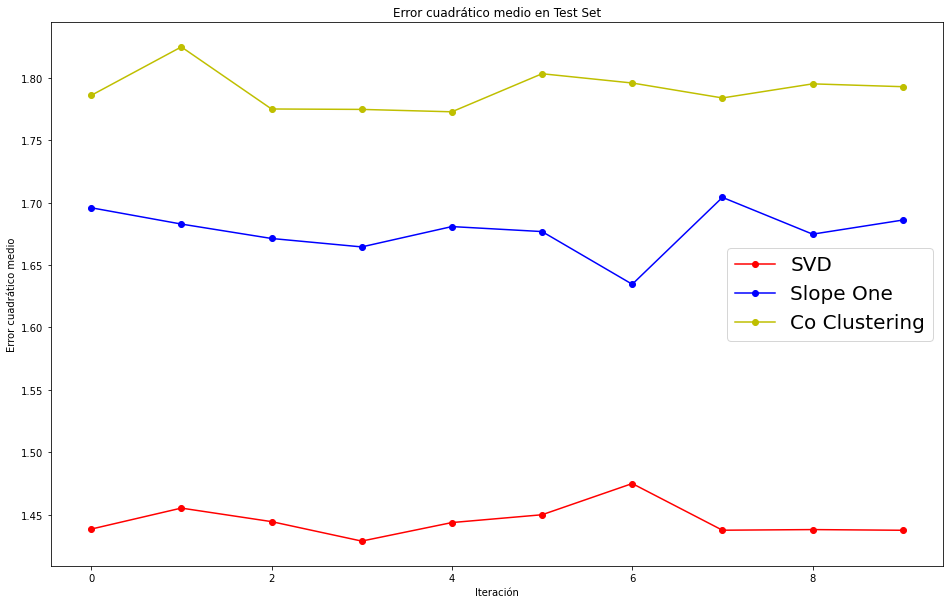

In [30]:
plt.figure(figsize=(16,10))
plt.ylabel("Error cuadrático medio")
plt.xlabel("Iteración")
plt.plot(range(10),r1['test_rmse'],'-o',color='r',label="SVD")
plt.plot(range(10),r2['test_rmse'],'-o',color='b',label="Slope One")
plt.plot(range(10),r3['test_rmse'],'-o',color='y',label="Co Clustering")
plt.legend(loc="right",prop={'size':20})
plt.title("Error cuadrático medio en Test Set")

In [136]:
from collections import defaultdict

from surprise import Dataset



def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(prediciontsSVD, n=10)

unique = []
name = 'Stark700'
for uid,_ in top_n[name]:
    lista = animes.loc[uid,'title']
    lista = list(dict.fromkeys(lista))
    if lista[0] not in unique:
        unique.append(lista[0])
print("Recomendación SVD:")
print(name+":")
for el in unique:
    print("\t",el)
print()    

top_n2 = get_top_n(predictionsSlopeOne, n=10)

unique = []
name = 'Stark700'
for uid,_ in top_n2[name]:
    lista = animes.loc[uid,'title']
    lista = list(dict.fromkeys(lista))
    if lista[0] not in unique:
        unique.append(lista[0])
print("Recomendación Slope One:")
print(name+":")
for el in unique:
    print("\t",el)
print()

top_n3 = get_top_n(predictionscoClustering, n=10)

unique = []
name = 'Stark700'
for uid,_ in top_n3[name]:
    lista = animes.loc[uid,'title']
    lista = list(dict.fromkeys(lista))
    if lista[0] not in unique:
        unique.append(lista[0])
print("Recomendación Co Clustering:")
print(name+":")
for el in unique:
    print("\t",el)


Recomendación SVD:
Stark700:
	 Ping Pong the Animation
	 Monogatari Series: Second Season
	 Shouwa Genroku Rakugo Shinjuu
	 High Score Girl
	 Mob Psycho 100 II
	 Ookami Kodomo no Ame to Yuki
	 Yagate Kimi ni Naru
	 Zetsuen no Tempest

Recomendación Slope One:
Stark700:
	 Shouwa Genroku Rakugo Shinjuu
	 G
	 Ping Pong the Animation
	 Mahou Shoujo Madoka★Magica Movie 2: Eien no Monogatari
	 Kara no Kyoukai: Mirai Fukuin
	 Vinland Saga
	 Haikyuu!!
	 Shingeki no Bahamut: Genesis
	 Shirobako

Recomendación Co Clustering:
Stark700:
	 Haikyuu!!
	 Sora yori mo Tooi Basho
	 Kuroko no Basket: Tip Off
	 Bakuman. 3rd Season
	 K
	 Mob Psycho 100 II
	 Mahou Shoujo Madoka★Magica Movie 2: Eien no Monogatari
	 Gin no Saji 2nd Season
	 Ping Pong the Animation
